## This is the first notebook. Here we try to make the optimal portfolio using the assests in Data\

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os
import datetime as dt

import pandas_datareader as pdr
from pandas_datareader._utils import RemoteDataError

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# data_frames = [ pd.read_csv(os.getcwd()+'\\Data\\'+'AAL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAL"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'AAPL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAPL"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'BAC.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "BAC"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'F.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "F"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'PFE.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "PFE"})]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
#                             how='outer'), data_frames)
# df_merged['Date'] = pd.to_datetime(df_merged['Date'])
# # df_merged = df_merged.set_index('Date')
# df_merged.head()

In [3]:
def fetch_data(tickers=["TSLA", "AAPL", "MSFT"], start_date=dt.datetime.today().date()-dt.timedelta(weeks=50), end_date=dt.datetime.today()):
    bad_tickers = []
    res = pd.DataFrame(pd.date_range(
        start=start_date, end=end_date), columns=["Date"])
    for i in range(len(tickers)):
        try:
            curr = pdr.get_data_yahoo(tickers[i], start=start_date, end=end_date,)[
                ["Adj Close"]].rename(columns={"Adj Close": tickers[i]}).reset_index()
        except RemoteDataError:
            bad_tickers.append(tickers[i])
            continue
        res = pd.merge(res, curr, on=['Date'], how='outer')
    return res.dropna(axis=0), bad_tickers

In [4]:
df_merged,bad_tickers = fetch_data()
df_merged

Date         TSLA        AAPL        MSFT
0   2020-12-15   633.250000  127.096481  212.350037
1   2020-12-16   622.770020  127.026901  217.457199
2   2020-12-17   655.900024  127.911446  217.596054
3   2020-12-18   695.000000  125.883957  216.772934
6   2020-12-21   649.859985  127.444328  220.739685
..         ...          ...         ...         ...
343 2021-11-23  1109.030029  161.410004  337.679993
344 2021-11-24  1116.000000  161.940002  337.910004
346 2021-11-26  1081.920044  156.809998  329.679993
349 2021-11-29  1136.989990  160.240005  336.630005
350 2021-11-30  1134.000000  162.994995  331.230011

[242 rows x 4 columns]

<AxesSubplot:xlabel='Date', ylabel='value'>

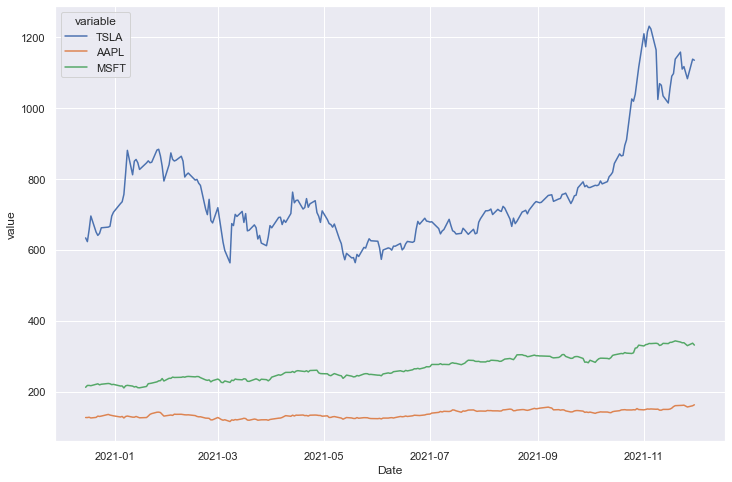

In [5]:
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(df_merged,id_vars='Date'))

In [6]:
# Daily and annual returns
returns_daily = df_merged.set_index("Date").pct_change()
returns_annual = returns_daily.mean() * 250

# Daily and annual covariance of returns
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

<AxesSubplot:xlabel='Date', ylabel='value'>

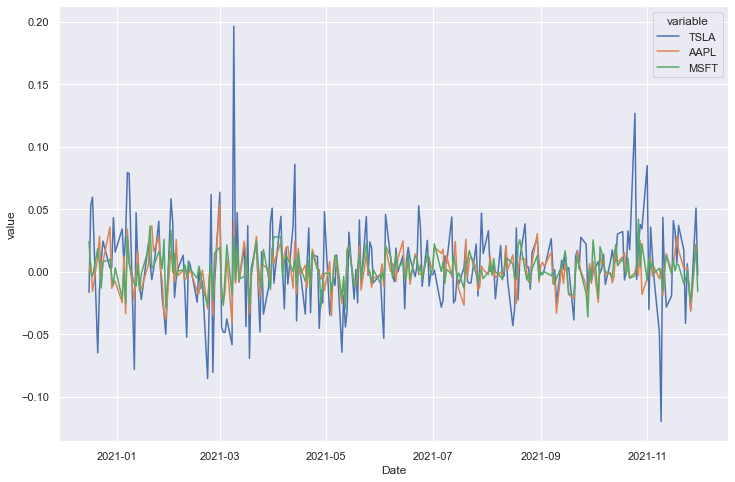

In [7]:
# Daily returns
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(returns_daily.reset_index(), id_vars='Date'))


<AxesSubplot:>

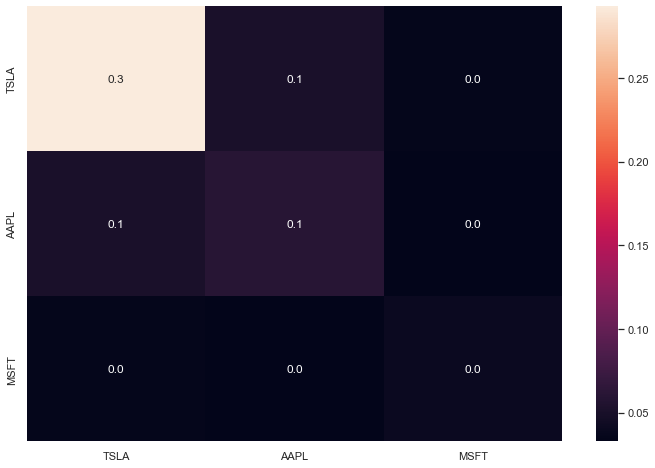

In [8]:
# Covariance matrix
sns.heatmap(cov_annual,annot=True,fmt=".1f")

In [9]:
p_returns = []
p_volatility = []
sharpe_ratios = []
asset_weights = []

# set the number of combinations for imaginary portfolios
n_assets = len(df_merged.columns)-1
n_portfolios = 2000

#set random seed for reproduction's sake
np.random.seed(101)

### Simulate different portfolios by giving each asset a random weight. Basically Monte Carlo (MC) method with uniform a priori distribution.

In [10]:
risk_free_rate = 0.01482 # 10 year US bond yield
for i in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    returns = np.dot(w, returns_annual)
    volatility = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    sharpe = (returns-risk_free_rate) / volatility
    sharpe_ratios.append(sharpe)
    p_returns.append(returns)
    p_volatility.append(volatility)
    asset_weights.append(w)

In [11]:
df_w = pd.DataFrame(asset_weights,columns=["Weight: "+ s for s in returns_daily.columns.tolist()])
df_kpi = pd.DataFrame.from_dict({"Returns":p_returns,
"Volatility":p_volatility,
"Sharpe Ratio":sharpe_ratios})
res = pd.concat([df_kpi,df_w],axis=1)
# pd.concat([df_kpi.iloc[0:5,],df_w.iloc[0:5,]],axis=1)
res

Returns  Volatility  Sharpe Ratio  Weight: TSLA  Weight: AAPL  \
0     0.506325    0.322973      1.521816      0.462913      0.511562   
1     0.430454    0.208945      1.989203      0.101450      0.405323   
2     0.434451    0.222372      1.887066      0.159702      0.464909   
3     0.430193    0.227727      1.823993      0.173255      0.505544   
4     0.428280    0.207944      1.988323      0.094100      0.406421   
...        ...         ...           ...           ...           ...   
1995  0.582615    0.288131      1.970611      0.420812      0.059940   
1996  0.477295    0.232626      1.988067      0.227375      0.337020   
1997  0.340547    0.221801      1.468552      0.015982      0.751547   
1998  0.481689    0.260992      1.788827      0.308021      0.425396   
1999  0.420001    0.227263      1.782868      0.161005      0.541266   

      Weight: MSFT  
0         0.025525  
1         0.493227  
2         0.375389  
3         0.321201  
4         0.499480  
...            ...  
1995      0.519248  
1996      0.435605  
1997      0.232471  
1998      0.266583  
1999      0.297729  

[2000 rows x 6 columns]

### Plot the simulated portfolios in the mean-volatility space.

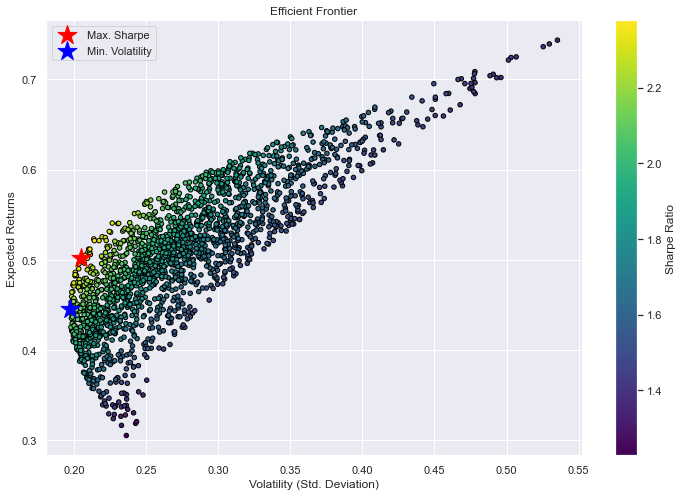

In [12]:
fig, ax = plt.subplots() # Known bug from 2015 onwards, X axis does not show up with pandas+matplotlib when using colourbar
res.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', ax=ax)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Find the minimum volatiliy and maximum sharpe portfolios
min_volatility_idx = res['Volatility'].argmin()
max_sharpe_idx = res['Sharpe Ratio'].argmax()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df_kpi.loc[max_sharpe_idx]
min_variance_port = df_kpi.loc[min_volatility_idx]

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='*', s=400,label="Max. Sharpe")
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='*', s=400,label="Min. Volatility")
plt.legend()

In [13]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [17]:

def show_results(res):

    min_volatility_idx = res['Volatility'].argmin()
    max_sharpe_idx = res['Sharpe Ratio'].argmax()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = res.loc[max_sharpe_idx]
    min_variance_port = res.loc[min_volatility_idx]

    min_variance_port_frame = min_variance_port.to_frame(name="Minimum volatility portfolio")
    sharpe_portfolio_frame = sharpe_portfolio.to_frame(name="Maximum Sharpe portfolio")
    opt_portfolios = min_variance_port_frame.T.append(sharpe_portfolio_frame.T)

    opt_portfolios = min_variance_port_frame.T.append(sharpe_portfolio_frame.T)
    # TABLE
    fig_tbl = ff.create_table(opt_portfolios.round(2).reset_index().rename(columns={'index':"Portfolio Type"}))
    
    # SCATTERPLOT
    fig = px.scatter(res[["Returns","Volatility","Sharpe Ratio"]],
    x="Volatility",y="Returns",
    hover_data=("Returns","Volatility"), template="seaborn",
    color="Sharpe Ratio",color_continuous_scale ='viridis',height=600,width=1250)


    fig.update_layout(xaxis_range=[min(res["Volatility"])-0.1,max(res["Volatility"])+0.1])
    fig.update_layout(yaxis_range=[min(res["Returns"])-0.1,max(res["Returns"])+0.1])


    fig.update_traces(marker=dict(size=5,
                                line=dict(width=1,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))


    fig.add_trace(
        go.Scatter(
            x=[sharpe_portfolio['Volatility']],
            y=[sharpe_portfolio['Returns']],
            mode="markers+text",
            showlegend=False,marker_symbol="star", marker_color="red",
                            marker_line_width=1, marker_size=20,text="Max. Sharpe ratio portfolio",textposition="middle left",textfont_size=14)
    )
    fig.add_trace(
        go.Scatter(
            x=[min_variance_port['Volatility']],
            y=[min_variance_port['Returns']],
            mode="markers+text",
            showlegend=False,marker_symbol="star", marker_color="blue",
                            marker_line_width=1, marker_size=20,text="Min. Volatility portfolio",textposition="middle left",textfont_size=14)
    )

    fig.update_layout(
        title={
            'text': "Simulated portfolios and the efficient frontier",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    return fig,fig_tbl
fig,fig_tbl = show_results(res)
fig.show()

In [64]:
def create_plot(res):
    # Find the minimum volatiliy and maximum sharpe portfolios
    min_volatility_idx = res['Volatility'].argmin()
    max_sharpe_idx = res['Sharpe Ratio'].argmax()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = res.loc[max_sharpe_idx]
    min_variance_port = res.loc[min_volatility_idx]

    fig = px.scatter(res[["Returns","Volatility","Sharpe Ratio"]],
    x="Volatility",y="Returns",
    hover_data=("Returns","Volatility"), template="seaborn",
    color="Sharpe Ratio",color_continuous_scale ='viridis')


    fig.update_layout(xaxis_range=[min(res["Volatility"])-0.1,max(res["Volatility"])+0.1])
    fig.update_layout(yaxis_range=[min(res["Returns"])-0.1,max(res["Returns"])+0.1])


    fig.update_traces(marker=dict(size=5,
                                line=dict(width=1,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))


    fig.add_trace(
        go.Scatter(
            x=[sharpe_portfolio['Volatility']],
            y=[sharpe_portfolio['Returns']],
            mode="markers+text",
            showlegend=False,marker_symbol="star", marker_color="red",
                            marker_line_width=1, marker_size=20,text="Max. Sharpe ratio portfolio",textposition="middle left",textfont_size=14)
    )
    fig.add_trace(
        go.Scatter(
            x=[min_variance_port['Volatility']],
            y=[min_variance_port['Returns']],
            mode="markers+text",
            showlegend=False,marker_symbol="star", marker_color="blue",
                            marker_line_width=1, marker_size=20,text="Min. Volatility portfolio",textposition="middle left",textfont_size=14)
    )

    fig.update_layout(
        title={
            'text': "Simulated portfolios and the efficient frontier",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    return fig
create_plot(res).show()

In [8]:
st = 'MSFT,AAPL, AMD'
lst = st.split(",")
lst = [s.strip() for s in lst]
lst

['MSFT', 'AAPL', 'AMD']